In [351]:
import numpy as np
import pandas as pd
import tqdm
import pickle
from sympy import plot_implicit, Eq, symbols, exp
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d
from itertools import product
from pandas import DataFrame
%matplotlib inline

# Question 1

## Data Distribution and Generation

In [358]:
mu1 = np.array([1,0,-1]).reshape(3,1)
mu2 = np.array([1,1,-1]).reshape(3,1)
mu3 = np.array([0,1,-1]).reshape(3,1)
mu4 = np.array([0,0,-1]).reshape(3,1)
sigma1 = np.array([[0.12,0,0],
                   [0,0.12,0],
                   [0,0,0.12]])
sigma2 = np.array([[0.14,0,0],
                   [0,0.14,0],
                   [0,0,0.14]])
sigma3 = np.array([[0.16,0,0],
                   [0,0.16,0],
                   [0,0,0.16]])
sigma4 = np.array([[0.18,0,0],
                   [0,0.18,0],
                   [0,0,0.18]])
mu_list = [mu1,mu2,mu3,mu4]
sigma_list = [sigma1,sigma2,sigma3,sigma4]

In [359]:
def data_generation(mu_list, sigma_list, size):
    rs = np.random.RandomState(233)
    d1 = rs.multivariate_normal(mu_list[0].flatten(), sigma_list[0], size)
    d2 = rs.multivariate_normal(mu_list[1].flatten(), sigma_list[1], size)
    d3 = rs.multivariate_normal(mu_list[2].flatten(), sigma_list[2], size)
    d4 = rs.multivariate_normal(mu_list[3].flatten(), sigma_list[3], size)
    manul_label = [0]* int(size/4) + [1]* int(size/4 )+ [2]* int(size/4) + [3]* int(size/4)
    random.shuffle(manul_label)
    label = np.array(manul_label).reshape(size,1)
    data = d1 * (label == 0) + d2 * (label == 1) + d3 * (label == 2) + d4 * (label == 3)
    return data, label

In [360]:
data_train_100, label_100 = data_generation(mu_list, sigma_list, 100)

In [361]:
data_train_200, label_200  = data_generation(mu_list, sigma_list, 200)

In [362]:
data_train_500, label_500  = data_generation(mu_list, sigma_list, 500)

In [363]:
data_train_1000, label_1000  = data_generation(mu_list, sigma_list, 1000)

In [364]:
data_train_2000, label_2000  = data_generation(mu_list, sigma_list, 2000)

In [365]:
data_train_5000, label_5000  = data_generation(mu_list, sigma_list, 5000)

In [366]:
data_test_100000, label_100000  = data_generation(mu_list, sigma_list, 100000)

In [367]:
dataset_list = [data_train_100, data_train_200, data_train_500, data_train_1000, data_train_2000, data_train_5000]

In [368]:
data_train_100[(label_100 == 0).flatten()][:,0]

array([1.50419376, 1.40303152, 0.97926511, 0.92283872, 1.29339959,
       1.71537363, 0.68897844, 0.75186409, 0.40490369, 1.46074084,
       0.5309526 , 0.99434889, 0.77190002, 1.31106317, 1.07126709,
       1.16312722, 1.76406218, 0.68394042, 1.19892481, 1.42451806,
       0.77359692, 0.97353573, 0.9444369 , 0.21407084, 0.77820611])

In [411]:
def plot_data_distribution(data, data_label, number_sample):
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection ="3d")

    ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 

    ax.scatter3D(data[(data_label == 0).flatten()][:,0], 
                 data[(data_label == 0).flatten()][:,1],
                 data[(data_label == 0).flatten()][:,2],
                 color='lime', s = 15, marker = ".", alpha=0.8, label = 'C0')
    ax.scatter3D(data[(data_label == 1).flatten()][:,0], 
                 data[(data_label == 1).flatten()][:,1],
                 data[(data_label == 1).flatten()][:,2],
                 color='aqua', s = 15, marker = ".", alpha=0.8, label = 'C1')
    ax.scatter3D(data[(data_label == 2).flatten()][:,0], 
                 data[(data_label == 2).flatten()][:,1],
                 data[(data_label == 2).flatten()][:,2],
                 color='blue', s = 15, marker = ".", alpha=0.8, label = 'C2')
    ax.scatter3D(data[(data_label == 3).flatten()][:,0], 
                 data[(data_label == 3).flatten()][:,1],
                 data[(data_label == 3).flatten()][:,2],
                 color='hotpink', s = 15, marker = ".", alpha=0.8, label = 'C3')
    plt.title('D{}'.format(str(number_sample)))
    plt.legend()
    ax.set_xlabel('X-axis', fontweight ='bold') 
    ax.set_ylabel('Y-axis', fontweight ='bold') 
    ax.set_zlabel('Z-axis', fontweight ='bold')

    plt.show()

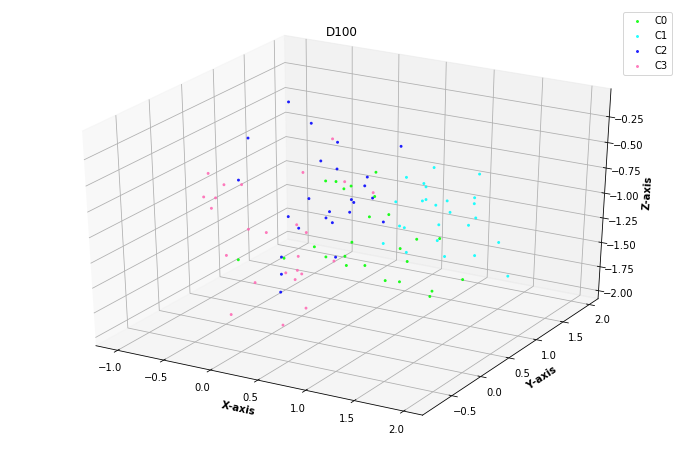

In [412]:
plot_data_distribution(data_train_100, label_100, 100)

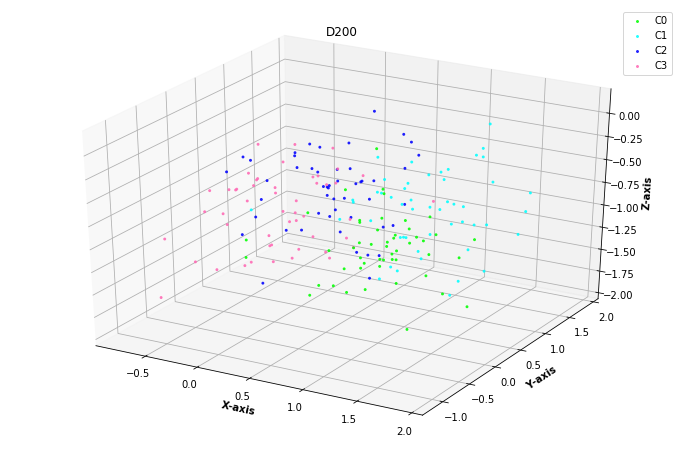

In [413]:
plot_data_distribution(data_train_200, label_200, 200)

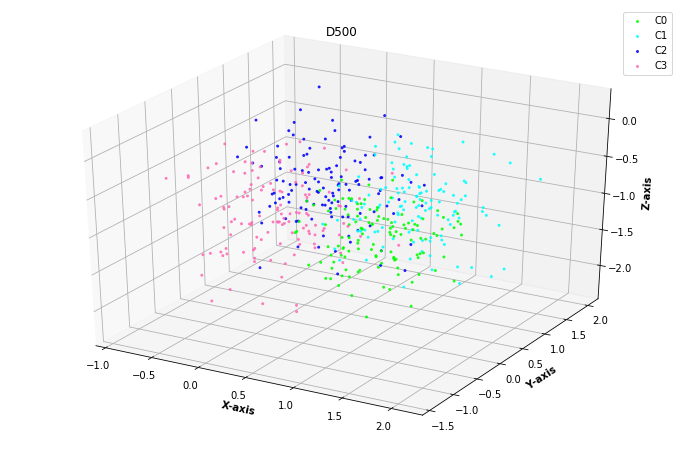

In [414]:
plot_data_distribution(data_train_500, label_500, 500)

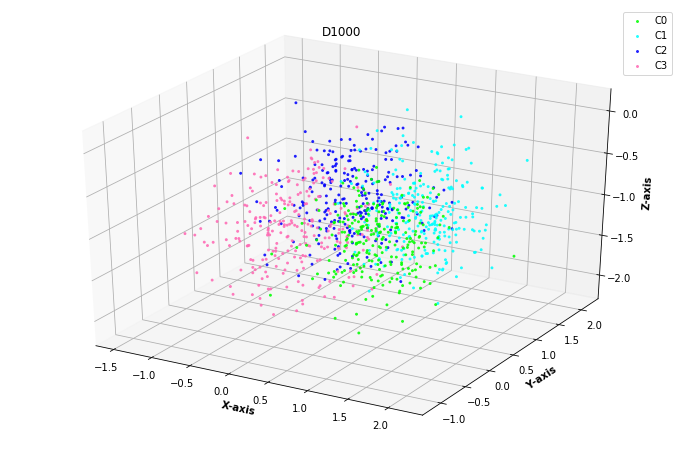

In [415]:
plot_data_distribution(data_train_1000, label_1000, 1000)

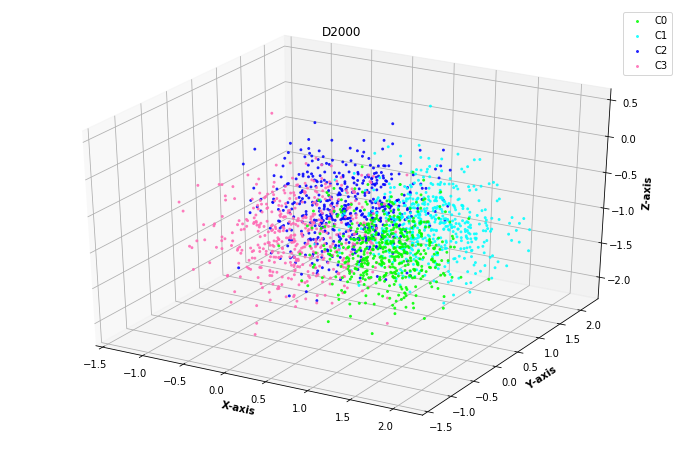

In [416]:
plot_data_distribution(data_train_2000, label_2000, 2000)

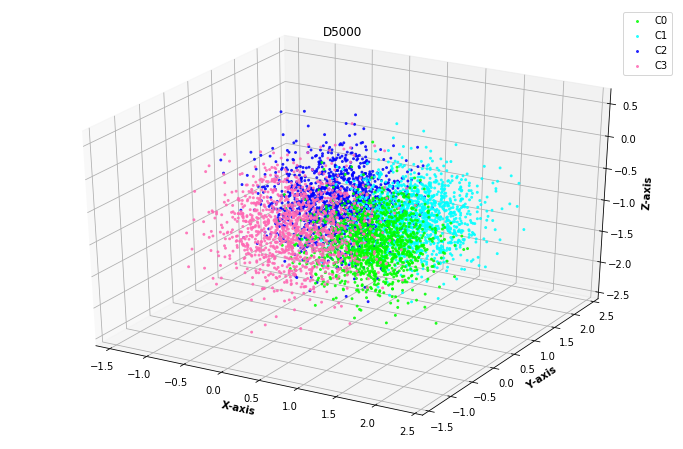

In [417]:
plot_data_distribution(data_train_5000, label_5000, 5000)

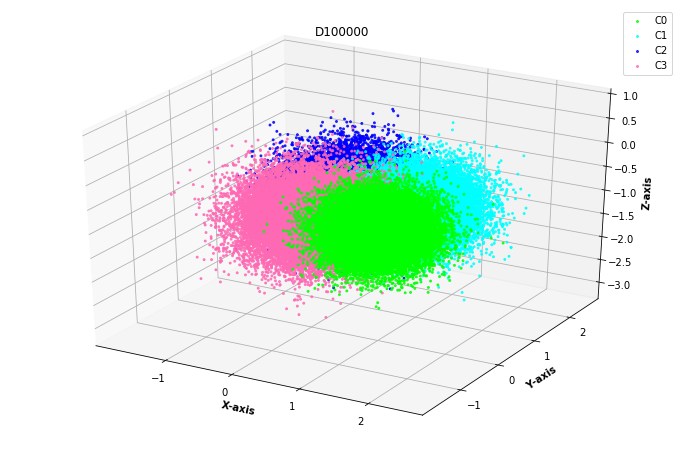

In [418]:
plot_data_distribution(data_test_100000, label_100000, 100000)

## MLP Structure

In [374]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [375]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyMLP, self).__init__()
        
        self.input_hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_output = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, data):
        """
        data: shape [batch, ..., c_in=input_size]
        output: shape [batch, ..., c_out=output_size]
        """
        
        z = self.input_hidden(data)
        a = F.elu(z)
        
        z2 = self.hidden_output(a)
        output = F.softmax(z2)
        
        return output
    
def train_one_epoch(model, data, gt):
    
    model.train()
    model.zero_grad()
    prediction = model(data)
    loss = F.cross_entropy(prediction, gt)
    return loss

def validation(model, data, gt):
    
    model.eval()
    with torch.no_grad():
        prediction = model(data)
        loss = F.cross_entropy(prediction, gt)
    return loss

## Theoretically Optimal classifier

In [369]:
class TheoreticallyOptimalClassifier(object):
    def __init__(self, mu_list, sigma_list):
        n = mu_list[0].shape[0]
        c1_inv = np.linalg.inv(sigma_list[0])
        c2_inv = np.linalg.inv(sigma_list[1])
        c3_inv = np.linalg.inv(sigma_list[2])
        c4_inv = np.linalg.inv(sigma_list[3])
        constant1 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(sigma_list[0]) ** (1/2))
        constant2 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(sigma_list[1]) ** (1/2))
        constant3 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(sigma_list[2]) ** (1/2))
        constant4 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(sigma_list[3]) ** (1/2))
        self.cache = (mu_list,sigma_list,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4)
        
                     
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, p1, p2, p3, p4):        
        mu_list,sigma_list,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4 = self.cache
    
        likelihood1 = (self.get_gaussian(data, constant1, mu_list[0], c1_inv) * p1).tolist()
        likelihood2 = (self.get_gaussian(data, constant2, mu_list[1], c2_inv) * p2).tolist()
        likelihood3 = (self.get_gaussian(data, constant3, mu_list[2], c3_inv) * p3).tolist()
        likelihood4 = (self.get_gaussian(data, constant4, mu_list[3], c4_inv) * p4).tolist()
        
        return np.argmax(np.array([likelihood1,likelihood2,likelihood3,likelihood4]), axis = 0) 
    

In [370]:
MAP_rule = TheoreticallyOptimalClassifier(mu_list, sigma_list)
MAP_pred = MAP_rule(data_test_100000,0.25,0.25,0.25,0.25)[:,np.newaxis]

In [371]:
Optimal_classifier_P_error =  1 - (MAP_pred == label_100000).sum()/100000

In [372]:
Optimal_classifier_P_error

0.18413999999999997

## Model order selection

In [376]:
def k_fold(dataset, label, k):
    data_size = len(dataset)
    step = data_size // k
    index = np.arange(k) * step
    for i in range(k):
        val_index = np.arange(index[i], index[i] + step)
        train_index = list(set(range(data_size)).difference(val_index))
        yield dataset[train_index], dataset[val_index], label[train_index], label[val_index]

In [377]:
def model_order_selection(dataset, label):   
    accuracy_result = dict()
    model_result = dict()

    for num_node in range(1,16):
        model = MyMLP(3, num_node, 4)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        schedular = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.95, verbose=False)

        accuracy = list()
        model_list = list()
        
        dataAndlabel = [(train, val, train_label, val_label, i) for i,
                        (train, val, train_label, val_label) in enumerate(k_fold(dataset, label, 10))]
        for j in range (0,10):
            train_data = torch.tensor(np.array(dataAndlabel)[j,0], dtype=torch.float32)
            val_data = torch.tensor(np.array(dataAndlabel)[j,1], dtype=torch.float32)
            train_gt = torch.tensor(np.array(dataAndlabel)[j,2], dtype=torch.long).squeeze(-1)
            val_gt = torch.tensor(np.array(dataAndlabel)[j,3], dtype=torch.long).squeeze(-1)

            epochs = 100
            train_loss_list = list()
            val_loss_list = list()

            for epoch in range(epochs):
                train_loss = train_one_epoch(model, train_data, train_gt)
                train_loss_list.append(train_loss)
    
                train_loss.backward() ## calculate gradients
                optimizer.step()  ## optimize parameters
                schedular.step()  ## optimize learning rate
    
                val_loss = validation(model, val_data, val_gt)
                val_loss_list.append(val_loss)
                if len(val_loss_list) == 1:
                    continue
                elif val_loss > val_loss_list[-2]:
                    break 
                
            pred_prob = model(torch.tensor(dataset, dtype=torch.float32))
            pred_label = torch.argmax(pred_prob,dim = 1).numpy()[:,np.newaxis]
            accuracy.append((label == pred_label).sum() / len(dataset))
            model_list.append(model)
        
        accuracy_result[num_node] = accuracy
        model_result[num_node] = model_list
    return accuracy_result,model_result

                

In [378]:
result_100, model_100 = model_order_selection(data_train_100, label_100)
result_200, model_200 = model_order_selection(data_train_200, label_200)
result_500, model_500 = model_order_selection(data_train_500, label_500)
result_1000, model_1000 = model_order_selection(data_train_1000, label_1000)
result_2000, model_2000 = model_order_selection(data_train_2000, label_2000)
result_5000, model_5000 = model_order_selection(data_train_5000, label_5000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [379]:
def num_node_select(result):
    accuracy = list()
    for i in range(1,16):
        accuracy.append(np.array(result[i]).mean())
    return np.array(accuracy).argmax() + 1

In [380]:
num_node_100 = num_node_select(result_100)
num_node_200 = num_node_select(result_200)
num_node_500 = num_node_select(result_500)
num_node_1000 = num_node_select(result_1000)
num_node_2000 = num_node_select(result_2000)
num_node_5000 = num_node_select(result_5000)

In [381]:
num_node_list = [num_node_100, num_node_200, num_node_500, num_node_1000, num_node_2000, num_node_5000]

In [382]:
num_node_list

[9, 15, 3, 15, 12, 11]

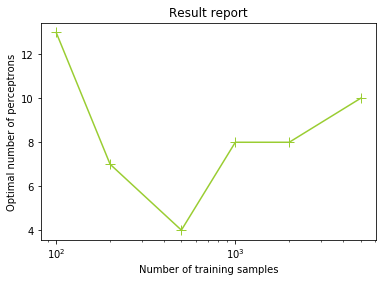

In [331]:
x = x_label

plt.semilogx(x, num_node_list, marker = "+", markersize = 10, color = "yellowgreen") 
plt.xlabel('Number of training samples')
plt.ylabel('Optimal number of perceptrons') 
plt.title('Result report')
plt.show()

In [177]:
BestModel_100 = model_100[num_node_list[0]][np.array(result_100[num_node_list[0]]).argmax()]
BestModel_200 = model_200[num_node_list[1]][np.array(result_100[num_node_list[1]]).argmax()]
BestModel_500 = model_500[num_node_list[2]][np.array(result_100[num_node_list[2]]).argmax()]
BestModel_1000 = model_1000[num_node_list[3]][np.array(result_100[num_node_list[3]]).argmax()]
BestModel_2000 = model_2000[num_node_list[4]][np.array(result_100[num_node_list[4]]).argmax()]
BestModel_5000 = model_5000[num_node_list[5]][np.array(result_100[num_node_list[5]]).argmax()]

## Model Performance Assessment 

In [178]:
def ModelPerformanceAssessment(model, test_data, test_data_label):
    test_prob = model(torch.tensor(test_data, dtype=torch.float32))
    test_label = torch.argmax(test_prob,dim = 1).numpy()[:,np.newaxis]
    error_prob = 1 - (test_label == test_data_label).sum() / 100000
    return error_prob

In [179]:
Model_100_P_error = ModelPerformanceAssessment(BestModel_100,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [180]:
Model_200_P_error = ModelPerformanceAssessment(BestModel_200,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [181]:
Model_500_P_error = ModelPerformanceAssessment(BestModel_500,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [182]:
Model_1000_P_error = ModelPerformanceAssessment(BestModel_1000,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [183]:
Model_2000_P_error = ModelPerformanceAssessment(BestModel_2000,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [184]:
Model_5000_P_error = ModelPerformanceAssessment(BestModel_5000,data_test_100000,label_100000)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Repot Process and Results

In [185]:
error_list = [Model_100_P_error, Model_200_P_error, Model_500_P_error,
              Model_1000_P_error, Model_2000_P_error, Model_5000_P_error]

In [186]:
x_label = [100, 200, 500, 1000, 2000, 5000]

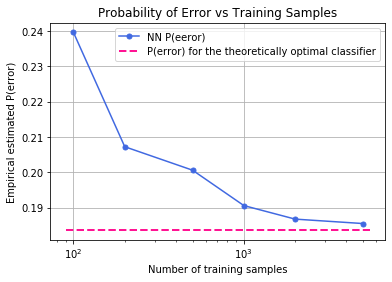

In [422]:
x = x_label
y = error_list

plt.semilogx(x, y, marker = ".", markersize = 10, color = "royalblue", label = 'NN P(eeror)')
plt.hlines(y = Optimal_classifier_P_error, xmin = 90, xmax = 5500, 
           colors='deeppink', linestyles = 'dashed', lw = 2, label= 'P(error) for the theoretically optimal classifier')

plt.grid(True) 
plt.xlabel('Number of training samples')
plt.ylabel('Empirical estimated P(error)') 
plt.title('Probability of Error vs Training Samples')
plt.legend()
plt.show()

# Question 2

## Generate Data

In [7]:
rs = np.random.RandomState(233)
mu_x = rs.rand(7,1)
sigma_x = np.array([[1,1,0,0,0,0,0],
                    [1,2,0,0,0,0,0],
                    [0,0,1,0,0,0,0],
                    [0,0,0,3,0,0,0],
                    [0,0,0,0,2,0,0],
                    [0,0,0,0,0,1,-0.2],
                    [0,0,0,0,0,-0.2,1]])

In [18]:
def get_z(alpha):
    rs = np.random.RandomState(233)
    mu_z = np.zeros((7,1))
    sigma_z = alpha * np.eye(7)
    z_train = rs.multivariate_normal(mu_z.flatten(), sigma_z, 100)
    z_test = rs.multivariate_normal(mu_z.flatten(), sigma_z, 10000)
    return z_train, z_test

## Model Parameter estimation

In [266]:
alpha_list = list()

In [267]:
for i in np.arange(-3,3,0.01):
        alpha_list.append(np.matrix.trace(sigma_x) * 10**(i)/7)

In [268]:
beta_list = list()

In [269]:
for i in np.arange(0.01,10,0.01):
        beta_list.append(i)

In [270]:
len(alpha_list),len(beta_list)

(600, 999)

In [285]:
def get_1D_guassian(data_x,data_y, parameters, variance):
    constant = 1 / ((2*np.pi)**(1/2) * (variance ** (1/2)))
    part1 = data_x @ parameters
    power = ((data_y - part1) / variance)**2
    return np.log(constant) + np.log(np.exp(-0.5 * power)) 

In [272]:
def model_parameter_estimation(mu_x, sigma_x, alpha_list, beta_list):
    rs = np.random.RandomState(233)
    a = rs.rand(7,1)
    x_train = rs.multivariate_normal(mu_x.flatten(), sigma_x, 100)
    x_test = rs.multivariate_normal(mu_x.flatten(), sigma_x, 10000)
    v_train = rs.normal(0,1,100)[:,np.newaxis]
    v_test = rs.normal(0,1,10000)[:,np.newaxis] 
    
    alpha_dict = dict()
    for alpha in alpha_list:
        z_train,z_test = get_z(alpha)
        y_train = (a.T @ (x_train + z_train).T + v_train.T).T
        y_test = (a.T @ (x_test + z_test).T + v_test.T).T
        
        dataAndlabel = [(train, val, train_label, val_label, i) for i,
                        (train, val, train_label, val_label) in enumerate(k_fold(x_train, y_train, 5))]
        
        avg_MSE = list()
        for beta in beta_list:
            MSE_list = list()
            for j in range (0,5):
                train_data = np.array(dataAndlabel)[j,0]
                val_data = np.array(dataAndlabel)[j,1]
                train_gt = np.array(dataAndlabel)[j,2]
                val_gt = np.array(dataAndlabel)[j,3]
                
                A = train_data.T @ train_data + (1 / beta**2 ) * np.eye(train_data.shape[1])
                b = train_data.T @ train_gt
                parameters = np.linalg.inv(A) @ b
                MSE = np.mean((val_gt - (val_data @ parameters))**2)
                MSE_list.append(MSE)
                
            avg_MSE.append(np.array(MSE_list).mean())
            
        alpha_dict[alpha] = avg_MSE
        
    return alpha_dict
 

In [273]:
result_mse = model_parameter_estimation(mu_x, sigma_x, alpha_list, beta_list)

In [274]:
def model_parameter_estimation_likelihood(mu_x, sigma_x, alpha_list, beta_list):
    rs = np.random.RandomState(233)
    a = rs.rand(7,1)
    x_train = rs.multivariate_normal(mu_x.flatten(), sigma_x, 100)
    #x_test = rs.multivariate_normal(mu_x.flatten(), sigma_x, 10000)
    v_train = rs.normal(0,1,100)[:,np.newaxis]
    #v_test = rs.normal(0,1,10000)[:,np.newaxis] 
    
    alpha_dict_prob = dict()
    for alpha in alpha_list:
        z_train,z_test = get_z(alpha)
        y_train = (a.T @ (x_train + z_train).T + v_train.T).T
        #y_test = (a.T @ (x_test + z_test).T + v_test.T).T
        
        dataAndlabel = [(train, val, train_label, val_label, i) for i,
                        (train, val, train_label, val_label) in enumerate(k_fold(x_train, y_train, 5))]
        
        avg_Prob = list()
        for beta in beta_list:
            Prob_list = list()
            for j in range (0,5):
                train_data = np.array(dataAndlabel)[j,0]
                val_data = np.array(dataAndlabel)[j,1]
                train_gt = np.array(dataAndlabel)[j,2]
                val_gt = np.array(dataAndlabel)[j,3]
                
                A = train_data.T @ train_data + (1 / beta**2 ) * np.eye(train_data.shape[1])
                b = train_data.T @ train_gt
                parameters = np.linalg.inv(A) @ b
                Prob = get_1D_guassian(val_data,val_gt,parameters,1)
                Prob_list.append(Prob)
                
            avg_Prob.append(np.array(Prob_list).mean())
            
        alpha_dict_prob[alpha] = avg_Prob
        
    return alpha_dict_prob

In [286]:
result_prob = model_parameter_estimation_likelihood(mu_x, sigma_x, alpha_list, beta_list)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


## Hyper-parameter Optimizetion

In [278]:
## select best beta for each alpha
best_beta_list = []
for key in result_mse.keys():
    index_min_mse = np.array(result_mse[key]).argmin()
    best_beta_list.append(beta_list[index_min_mse])

Text(0.5, 1.0, 'Beta selected by MSE VS Alpha')

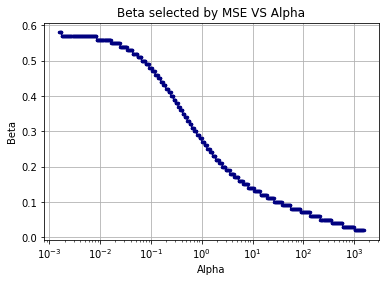

In [279]:
plt.plot(alpha_list, best_beta_list, marker = ".", markersize = 5, color = "navy")
plt.grid()
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Beta selected by MSE VS Alpha')

In [280]:
select_MSE_list = []
for key in result_mse.keys():
    select_MSE_list.append(np.array(result_mse[key]).min())

Text(0.5, 1.0, 'MSE using optimal Beta VS Alpha')

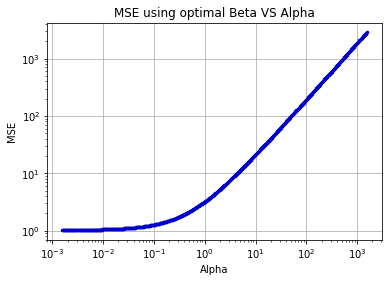

In [281]:
plt.plot(alpha_list, select_MSE_list, marker = ".", markersize = 5, color = "mediumblue")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE using optimal Beta VS Alpha')

In [287]:
best_beta_list_prob = []
for key in result_prob.keys():
    index_max_prob = np.array(result_prob[key]).argmax()
    best_beta_list_prob.append(beta_list[index_max_prob])

Text(0.5, 1.0, 'Beta selected by log-likelihood VS Alpha')

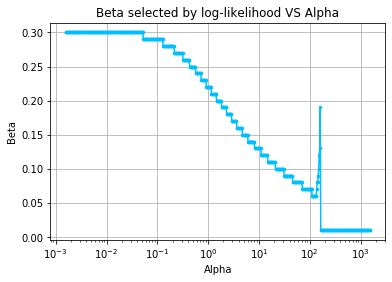

In [292]:
plt.plot(alpha_list, best_beta_list_prob, marker = ".", markersize = 5, color = "deepskyblue")
plt.grid()
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Beta selected by log-likelihood VS Alpha')

In [293]:
select_prob_list = []
for key in result_prob.keys():
    select_prob_list.append(np.array(result_prob[key]).max())

Text(0.5, 1.0, 'log-Likelihood using optimal Beta VS Alpha')

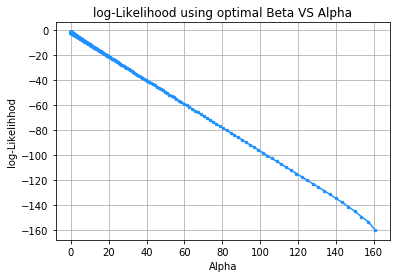

In [299]:
plt.plot(alpha_list, select_prob_list, marker = ".", markersize = 5, color = "dodgerblue")
plt.grid()
plt.xlabel('Alpha')
plt.ylabel('log-Likelihhod')
plt.title('log-Likelihood using optimal Beta VS Alpha')

## Model Optimization

In [407]:
def model_optimization_evaluation(alpha_list, beta_list, mu_x, sigma_x ):
    rs = np.random.RandomState(233)
    a = rs.rand(7,1)
    x_train = rs.multivariate_normal(mu_x.flatten(), sigma_x, 100)
    x_test = rs.multivariate_normal(mu_x.flatten(), sigma_x, 10000)
    v_train = rs.normal(0,1,100)[:,np.newaxis]
    v_test = rs.normal(0,1,10000)[:,np.newaxis] 
    
    evaluation_list = []
    for alpha, beta in zip(alpha_list, best_beta_list_prob):
     
        z_train,z_test = get_z(alpha)
        y_train = (a.T @ (x_train + z_train).T + v_train.T).T
        y_test = (a.T @ (x_test + z_test).T + v_test.T).T
        
        A = x_train.T @ x_train + (1 / beta**2 ) * np.eye(x_train.shape[1])
        b = x_train.T @ y_train
        parameters = np.linalg.inv(A) @ b
        
        evaluation = -2 * get_1D_guassian(x_test,y_test,parameters,1)
        evaluation_list.append(evaluation.mean())
        
    return evaluation_list
    
    

In [408]:
evaluation =  model_optimization_evaluation(alpha_list, best_beta_list_prob, mu_x, sigma_x)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0.5, 1.0, 'Model evaluation')

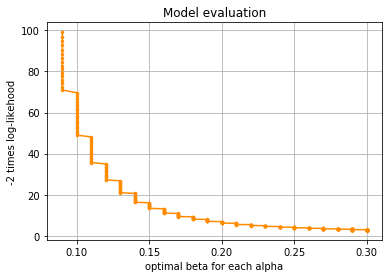

In [409]:
plt.plot(best_beta_list_prob, evaluation, marker = ".", markersize = 5, color = "darkorange")
plt.grid()
plt.xlabel('optimal beta for each alpha')
plt.ylabel('-2 times log-likehood')
plt.title('Model evaluation')

Text(0.5, 1.0, 'Model evaluation')

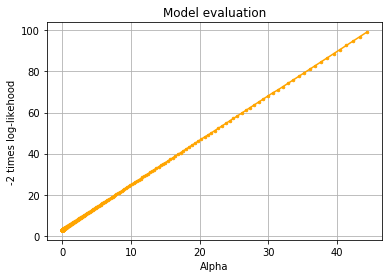

In [410]:
plt.plot(alpha_list, evaluation, marker = ".", markersize = 5, color = "orange")
plt.grid()
plt.xlabel('Alpha')
plt.ylabel('-2 times log-likehood')
plt.title('Model evaluation')